<a href="https://colab.research.google.com/github/DHANUSHGAMIDI/pytorch/blob/main/pytorch_imagesegmentationdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pl363c9x
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pl363c9x
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


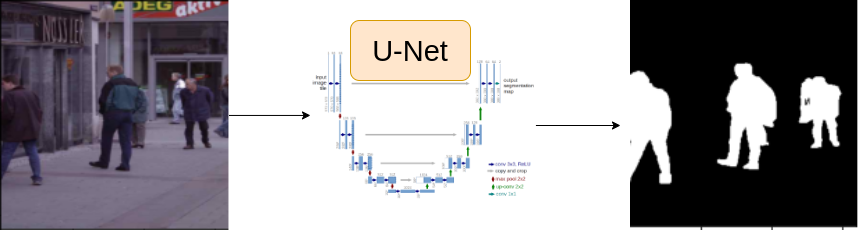

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
# get the first image at position 0 for visualization
row = df.iloc[0]

# use the .images attritute to get values and masks
image_path = row.images
mask_path = row.masks

# open cv2 to read the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

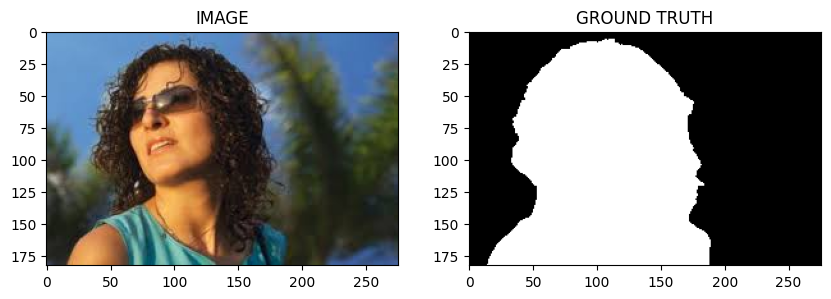

In [9]:
# Visualise the image and it ground truth
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(masks, cmap='gray')

In [10]:
# split the dataset into training and validation
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
# import library for augmentation
import albumentations as A

In [12]:
# function for training dataset augmentation
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])


# function for validation dataset augmentation
def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

    # the initial method for the dataframe and augmentation
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    # length of the dataframe
    def __len__(self):
        return len(self.df)

    # get item the image attributes
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w, c)
        mask = np.expand_dims(mask, axis=-1)

        if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

        # (h, w, c) -> (c, h, w)

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # convert from numpy to tensor
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [15]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


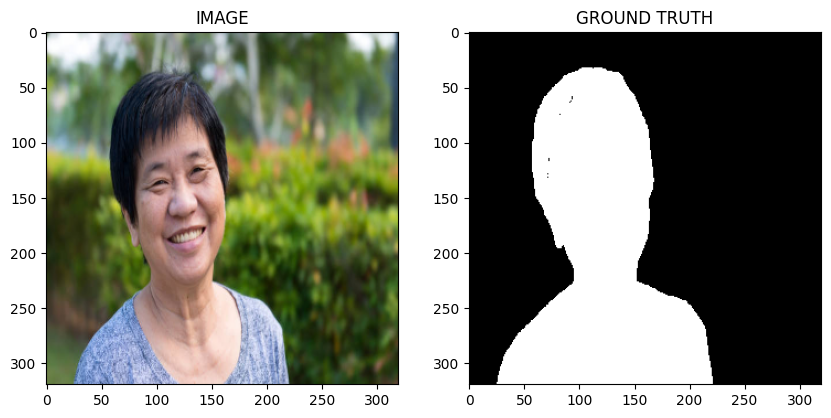

In [17]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [21]:
for image, mask in trainloader:
    break
print(f"Image shape : {image.shape}")
print(f"Mask shape : {mask.shape}")

Image shape : torch.Size([16, 3, 320, 320])
Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [3]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, mask=None):

        logits = self.arc(images)

        if mask is not None:
            loss1 = DiceLoss(mode="binary")(logits, mask)
            loss2 = nn.BCEWithLogitsLoss()(logits, mask)
            return logits, loss1 + loss2

        return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(model, dataloader, optimizer):
    model.train()
    train_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        optimizer.step()
        train_loss += loss.item()

        total_loss = train_loss / len(dataloader)
    return total_loss

In [25]:
def eval_fn(model, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images, masks)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(
        f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


SAVED-MODEL
EPOCH : 1 | Train Loss : 1.3317145903905232 | Valid Loss : 1.3198468387126923


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


EPOCH : 2 | Train Loss : 1.3356417735417685 | Valid Loss : 1.3320578932762146


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


EPOCH : 3 | Train Loss : 1.333917514483134 | Valid Loss : 1.3355785608291626


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


EPOCH : 4 | Train Loss : 1.3352941274642944 | Valid Loss : 1.3427118360996246


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


EPOCH : 5 | Train Loss : 1.332826590538025 | Valid Loss : 1.3414831459522247


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


EPOCH : 6 | Train Loss : 1.3326720635096232 | Valid Loss : 1.3421595394611359


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


EPOCH : 7 | Train Loss : 1.332798997561137 | Valid Loss : 1.344933807849884


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


EPOCH : 8 | Train Loss : 1.3272657155990601 | Valid Loss : 1.3454525470733643


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


EPOCH : 9 | Train Loss : 1.3351467768351237 | Valid Loss : 1.3430635631084442


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


EPOCH : 10 | Train Loss : 1.3329558690388998 | Valid Loss : 1.3410934507846832


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


EPOCH : 11 | Train Loss : 1.3325674613316854 | Valid Loss : 1.3424100875854492


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


EPOCH : 12 | Train Loss : 1.3313567241032918 | Valid Loss : 1.343348652124405


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


EPOCH : 13 | Train Loss : 1.335114598274231 | Valid Loss : 1.3457536697387695


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


EPOCH : 14 | Train Loss : 1.3359106302261352 | Valid Loss : 1.344563066959381


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


EPOCH : 15 | Train Loss : 1.3333115816116332 | Valid Loss : 1.3453016579151154


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


EPOCH : 16 | Train Loss : 1.3353347539901734 | Valid Loss : 1.34328693151474


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


EPOCH : 17 | Train Loss : 1.33332409063975 | Valid Loss : 1.3418019711971283


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


EPOCH : 18 | Train Loss : 1.3330233017603557 | Valid Loss : 1.3406330049037933


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


EPOCH : 19 | Train Loss : 1.3359175761540731 | Valid Loss : 1.3433539867401123


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


EPOCH : 20 | Train Loss : 1.3316564957300823 | Valid Loss : 1.3424827456474304


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH : 21 | Train Loss : 1.3297833601633708 | Valid Loss : 1.3444174230098724


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


EPOCH : 22 | Train Loss : 1.3300582726796468 | Valid Loss : 1.345255732536316


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


EPOCH : 23 | Train Loss : 1.3326586405436198 | Valid Loss : 1.3433670401573181


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


EPOCH : 24 | Train Loss : 1.336349121729533 | Valid Loss : 1.3418247997760773


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

EPOCH : 25 | Train Loss : 1.3337889671325684 | Valid Loss : 1.3419157266616821


# Task 9 : Inference

In [28]:
def inference(indx):
    idx = indx

    model.load_state_dict(torch.load('/content/best_model.pth'))

    image, mask = validset[idx]

    logits_mask = model(image.to(DEVICE).unsqueeze(0)
                        )  # (C, H, W) -> (1, C, H, W)
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5)*1.0

    return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

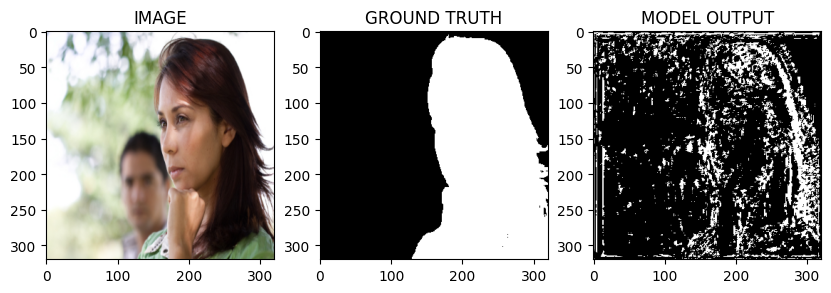

In [29]:
inference(3)

Linkedin :https://www.linkedin.com/in/dhanush-gamidi-24a908323/